<a href="https://colab.research.google.com/github/EugenioBugli/3DPointCloud/blob/main/PointCloud3D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports


In [1]:
%%capture
!pip install open3d
# !pip install torchinfo
!pip install torch_scatter

In [10]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
# from torchinfo import summary
from torchvision import transforms
import tqdm

import os
import numpy as np
import matplotlib.pyplot as plt
from torch_scatter import scatter_mean

import open3d as o3d
import plotly.graph_objects as go
import copy


if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using PyTorch version:', torch.__version__, ' Device:', device)

from google.colab import drive
drive.mount("/content/drive")

drive_path = "/content/drive/MyDrive/CV/MPI-FAUST"
training_path = drive_path + "/training"
test_path = drive_path + "/test"

Using PyTorch version: 2.4.1+cu121  Device: cpu
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Demo

In [ ]:
text_file = open(training_path+"/ground_truth_vertices/tr_gt_000.txt", "r")
lines = text_file.readlines()
print(len(lines))
vertices = []
for i in range(len(lines)):
    vertices.append(int(lines[i].rstrip('\n')))
text_file.close()

176387


In [ ]:
# Scan

cloud_mesh_scan = o3d.io.read_triangle_mesh(training_path+"/scans/tr_scan_000.ply")
np.asarray(cloud_mesh_scan.vertices)
cloud_mesh_scan.compute_vertex_normals()
cloud_mesh_scan.compute_triangle_normals()

TriangleMesh with 176387 points and 352169 triangles.

In [ ]:
# Registration

cloud_mesh_reg = o3d.io.read_point_cloud(training_path+"/registrations/tr_reg_000.ply")

In [ ]:
points_reg = np.asarray(cloud_mesh_reg.points)
colors_reg = np.asarray(cloud_mesh_reg.colors)
fig = go.Figure(
    data=[
        go.Scatter3d(
            x = points_reg[:,0], y=points_reg[:,1], z=points_reg[:,2],
            mode = 'markers',
            marker = dict(size=0.5, color=colors_reg)
        )
    ],
    layout=dict(
        scene=dict(
            xaxis=dict(visible=True),
            yaxis=dict(visible=True),
            zaxis=dict(visible=True),
        )
    )
)

fig.show()

In [ ]:
vert = np.asarray(cloud_mesh_scan.vertices)
triang = np.asarray(cloud_mesh_scan.triangles)
colors_scan = np.asarray(cloud_mesh_reg.colors)
fig = go.Figure(
    data=[
        go.Mesh3d(
            x = vert[:,0], y=vert[:,1], z=vert[:,2],
            i = triang[:,0], j=triang[:,1], k=triang[:,2],
            facecolor=colors_scan,
            opacity=0.50
        )
    ],
    layout=dict(
        scene=dict(
            xaxis=dict(visible=True),
            yaxis=dict(visible=True),
            zaxis=dict(visible=True),
        )
    )
)

fig.show()

In [ ]:
"""
    Example of what a Point Cloud looks like
"""
for cloud in train_loader:
    trainSet.plotCloud(cloud.numpy())
    break


Given a Point Cloud, each point represent a 3D coordinate. However, unlike in images, those points lie in a continuous and irregular space. Before defining the Local Pooling operation, we have to find a way to determine a neighborhood structure.

Coordinate Normalization:
Point Clouds may have various scales and translations. To overcome this, we have to center the point cloud at the origin and scale the coordinates within a standard range. This process is really important since makes the learning process more stable because we are focusing on the relative geometry of the point cloud.


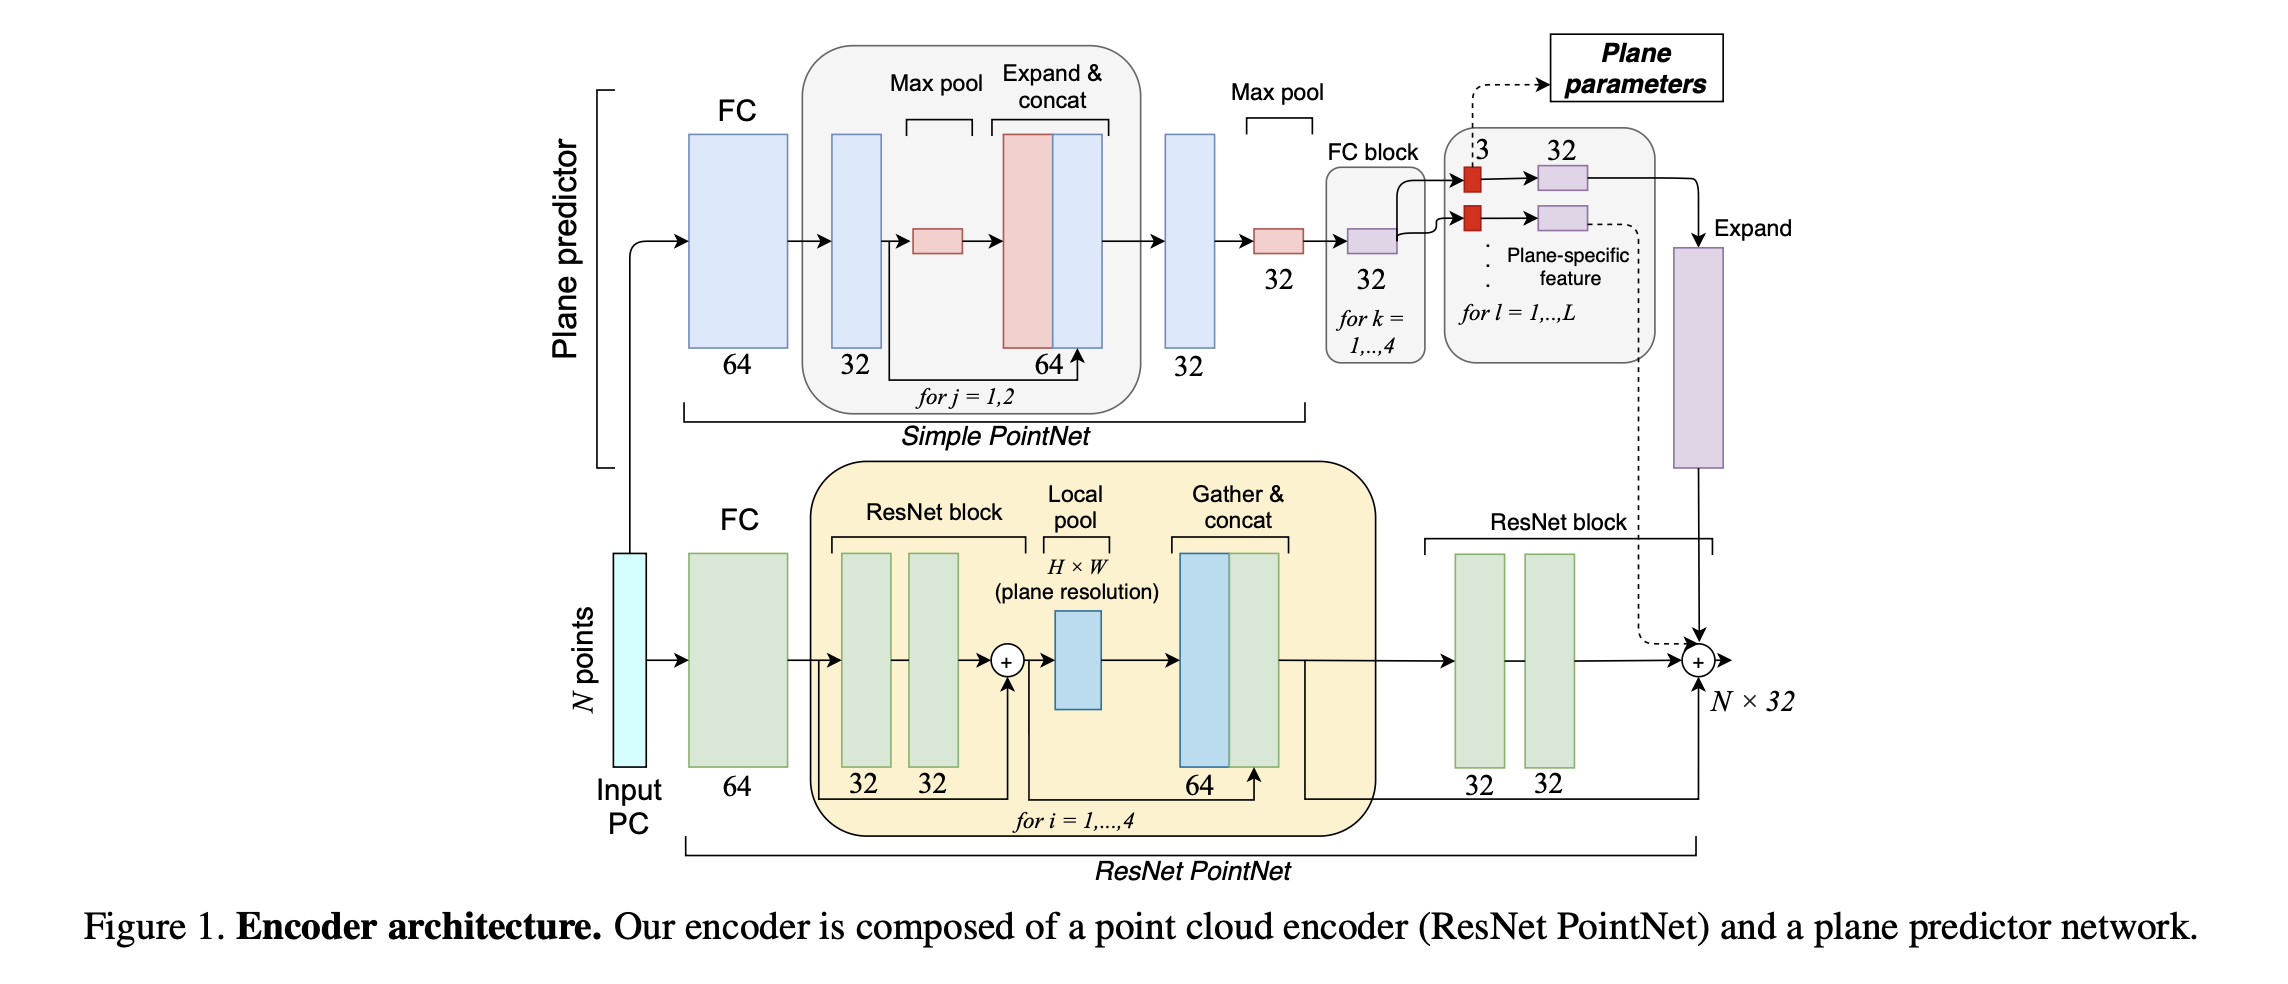

# 1] Dataset


In [116]:
class FAUST_Dataset(Dataset):
    """
        This class is used to load the FAUST dataset
    """

    def __init__(self, data_path, sampling_type="RANDOM", sampling_size=1024, transform=None):

        self.data_path = data_path
        self.SamplingType = sampling_type # either RANDOM or IMPORTANCE
        self.SamplingSize = sampling_size
        self.transform = transform
        self.clouds, self.ground_truth = self.importData(self.data_path)

    def __getitem__(self, index):
        print(self.clouds[index].shape, self.ground_truth[index].shape)
        if self.transform:
            return self.transform(self.clouds[index]).squeeze(0), self.transform(self.ground_truth[index]).squeeze(0)

        return self.clouds[index], self.ground_truth[index]

    def __len__(self):
        # num samples, num points, coordinates
        return self.clouds.shape[0]

    def importData(self, data_path):
        """
        This function is used to import the Dataset from Google Drive

        Args:
            data_path (str): path to the dataset

        Returns:
            torch.tensor: matrix of Point Clouds
        """

        sampled_mat = []
        gt_mat = dict()
        s = 0
        directory_path = data_path + "/scans/"
        for file in os.listdir(directory_path):
            if file.endswith(".ply"):
                cloud = o3d.io.read_point_cloud(directory_path + file)
                ground_truth = np.asarray(cloud.points)
                sampled_cloud = self.SamplingFunction(cloud)
                sampled_mat.append(sampled_cloud)
                gt_mat[s] = ground_truth
                s += 1

        return np.array(sampled_mat), gt_mat

    def plotCloud(self, cloud):
        """
        This function is used to plot the Point Cloud

        Args:
            cloud (np.array): Point Cloud

        Returns:
            None
        """
        if len(cloud.shape) == 3:
            # when using DataLoader you have a shape (1, SAMPLING_SIZE, 3)
            cloud = cloud[0]

        fig = go.Figure(
            data=[
            go.Scatter3d(
                x =cloud[:,0], y=cloud[:,1], z=cloud[:,2],
                mode = 'markers',
                marker = dict(size=0.5, color=[])
            )
        ],
        layout=dict(
            scene=dict(
                xaxis=dict(visible=True),
                yaxis=dict(visible=True),
                zaxis=dict(visible=True),
                )
            )
        )
        fig.show()

    def SamplingFunction(self, cloud):
        """
            This function is used to sample a small Subset of points from the Point Clouds inside our Dataset.

            @INPUT :
                > cloud : Point Cloud extracted from .ply file

            @OUTPUT :
                > sampled_cloud : Sampled Point Cloud
        """

        if self.SamplingType == 'RANDOM':
            points = np.asarray(cloud.points)
            indices = np.random.choice(len(points), size=self.SamplingSize)
            sampled_cloud = points[indices]
        if self.SamplingType == 'IMPORTANCE':
            numOfNeighbors = 20
            # estimate normal vectors to the surface at each point of the cloud
            cloud.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamKNN(knn=numOfNeighbors))
            tree = o3d.geometry.KDTreeFlann(cloud) # faster
            # loop over the points and compute curvature
            curvature = np.zeros(len(cloud.points))
            for i in range(len(cloud.points)):
                # find indices of the neighbors
                [_ , idx, _] = tree.search_knn_vector_3d(cloud.points[i], numOfNeighbors)
                neighbors = np.asarray(cloud.points)[idx, :]
                # compute covariance matrix for each point
                covarianceMat = np.cov(neighbors.T)
                # extract eigenvalues
                eigen, _ = np.linalg.eigh(covarianceMat)
                # compute curvature
                curvature[i] = min(eigen) / sum(eigen)
            # extract the best SamplingPoints points
            maxCurvaturePoints = curvature.argsort()[-self.SamplingSize:]
            sampled_cloud = np.asarray(cloud.points)[maxCurvaturePoints]

        return sampled_cloud

In [31]:
# Save your preprocessed Dataset:
def SaveDataset(dataset, path):
    torch.save(dataset, "/content/drive/MyDrive/CV/PreProcessed/"+path)

# Load your preprocessed Dataset:
def LoadDataset(path):
    return torch.load("/content/drive/MyDrive/CV/PreProcessed/"+path)

In [117]:
trainSet = FAUST_Dataset(training_path, sampling_type="RANDOM", sampling_size=1024, transform=transforms.ToTensor())
SaveDataset(trainSet, "trainSet_random.pt")

In [118]:
seT = LoadDataset("trainSet_random.pt")
train_loader = DataLoader(dataset=seT, batch_size=1, shuffle=True)

<ipython-input-31-a6d3b3ae149e>:7: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



In [120]:
for batch in train_loader:
    print(len(batch))
    print(batch[0].shape)
    print(batch[1].shape)
    seT.plotCloud(batch[0])
    seT.plotCloud(batch[1])
    break

(1024, 3) (153250, 3)
2
torch.Size([1, 1024, 3])
torch.Size([1, 153250, 3])


# 2] Encoder

## 2.1) ResBlock + Functions

In [6]:
class ResBlock(nn.Module):
    """
        This class is used to define a Residual Block, which is one of the main component of the ResNetPointNet architecture
    """

    def __init__(self, in_dim=64, n_points=1024, h_dim=32, out_dim=64):
        super(ResBlock, self).__init__()

        self.n_points = n_points

        #> First part of the Block

        self.fc1 = nn.Linear(
            in_dim,
            h_dim
        )
        self.bn1 = nn.BatchNorm1d(self.n_points)

        #> Second part of the Block

        self.fc2 = nn.Linear(
            h_dim,
            out_dim
        )
        self.bn2 = nn.BatchNorm1d(self.n_points)

        #> Skip connection

        if in_dim != out_dim:
            # size mismatch (never happen in my case)
            self.residual = nn.Linear(in_dim, out_dim)
        else:
            # same size
            self.residual = None


    def forward(self, x):
        # Input: (b,p,in_dim) = (b,p,64)

        first_part = F.relu(self.bn1(self.fc1(x))) # (b,p,64) -> (b,p,32)

        second_part = self.bn2(self.fc2(first_part)) # (b,p,32) -> (b,p,64)

        if self.residual is None:
            # no size mismatch
            res = x # (b,p,64)
        else:
            # transformation if there is a size mismatch in_dim != out_dim
            res = self.residual(x) # (b,p,in_dim) -> (b,p,64)

        # add residual connection
        third_part = second_part + res # (b,p,64) -> (b,p,64)

        return F.relu(third_part)

In [7]:
def CoordinateNormalization(input_cloud, planeType='xz'):
    """
        This Function is used to Normalize coordinates from the input point cloud.
        After this operation the cloud will be centered at the origin and all coordinates will be inside a standard range [0,1].
        The results will be the normalized point cloud focused only on the plane coordinate. This means that we will have only 2 coordinates for
        our points instead of 3.

        Args:
            input_cloud : (batch_size, n_points, 3) tensor
            planeType: (str) represent the kind of plane that we are using (xz, xy, yz)

        Returns:
            norm_cloud : (batch_size, n_points, 2) tensor
    """
    # Extract coordinates according to the planeType you are using
    if planeType == 'xz':
        plane = input_cloud[:, :, [0,2]] # (b,p,3) -> (b,p,2)
    elif planeType == 'xy':
        plane = input_cloud[:, :, [0,1]] # (b,p,3) -> (b,p,2)
    elif planeType == 'yz':
        plane = input_cloud[:, :, [1,2]] # (b,p,3) -> (b,p,2)


    norm_cloud = (plane - plane.min())/(plane.max() - plane.min() + 10e-6)

    return norm_cloud


def PlaneCoordinate2Index(input_cloud, voxel_size=1.0/64):
    """
        This function is used to Obtain an Index from the Plane Coordinates of the original input cloud.
        We need to transform Coordinates into Indices because we would like to discretize space into Voxels.
        This index is extremely important since is used to perform Local Pooling, one of the operation of the ResNetPointNet Architecture.

        Args:
            input_cloud : (batch_size, n_points, 2) tensor
            voxel_size : (float) represent how large the Voxels (Local Regions) are (default = 0.2)

        Returns:
            index : (batch_size, n_points, 2) tensor
    """
    return torch.floor(input_cloud/voxel_size).long()


def LocalPooling(norm_cloud, indices, input_cloud):
    """
        Unlike the Vanilla PointNet, we perform Local Max Pooling on the output of each ResBlock and then we concatenate the result
        with the features before the operation.
        In order to perform this operation we have to normalize the planes coordinates and transform into indices.
        These indices represent which voxel each point belongs to.

        ResBlock ________________
            |                    |
            |                    |
        LocalPool                |
            |                    |
            v                    |
            +   <----------------'

        Args:
            norm_cloud: (batch_size, num_points, 2) tensor that represent the normalized input cloud related to a specific plane (xz)
            indices: (batch_size, num_points, 2) tensor that represent the indices of the input cloud related to the Voxel
            input_cloud: (batch_size, num_points, n_features) tensor that represent the input cloud

        Returns:
            pool_cloud: tensor of shape (batch_size, num_points, n_features)
    """

    pool_cloud = torch.zeros_like(input_cloud)

    for b in range (norm_cloud.shape[0]):
        buckets = dict()

        # each point in the batch will have its own index along with the ones given by the PlaneCoordinate2Index transformation
        for i, voxel_idx in enumerate(indices[b]):
            # each point is identified by its own key (index)

            voxel_key = tuple(voxel_idx.tolist())
            if voxel_key not in buckets:
                buckets[voxel_key] = []

            # insert inside the correct bucket the point
            buckets[voxel_key].append(input_cloud[b][i])


        for voxel_key, points_list in buckets.items():
            # inside each buckets you have a list of points (tensors)

            if len(points_list) > 0:
                # extract the local maximum
                bucket_points = torch.stack(points_list)
                max_p = torch.max(bucket_points, dim=0)[0]

                # assign the maximum to all the points inside the buckets

                for i, voxel_idx in enumerate(indices[b]):
                    if torch.equal(voxel_idx, torch.Tensor(voxel_key)):
                        pool_cloud[b][i] = max_p
    return pool_cloud

## 2.2) ResNetPointNet

In [8]:
class ResNetPointNet(nn.Module):
    """
        This class is used to define the PointNet model used to form a feature embedding for each point in the Point Cloud given in input.
        Architecture design:

            @ INPUT: Tensor of shape (batch_size, num_points, 3)

            > Fully Connected Layer (3, in_dim=64)
            > 5 Residual Blocks with Local Pooling and Concatenation
            > Fully Connected Layer (out_dim=32, out_dim=32)

            @ OUTPUT: Tensor of shape (batch_size, num_points, 32)
    """

    def __init__(self, in_dim=64, n_points=1024, res_dim=32, out_dim=32, n_blocks=5):
        super(ResNetPointNet, self).__init__()

        self.fc1 = nn.Linear(3, in_dim)

        self.res = nn.ModuleList([
            ResBlock(in_dim, n_points, res_dim, out_dim) for n_res in range(n_blocks)
        ])

        self.fc2 = nn.Linear(out_dim, out_dim)

    def forward(self, x):
        # Input: (b,p,3)

        # Extract Normalized coordinates and indices to perform local pooling

        norm_coord = CoordinateNormalization(x) # (b,p,2)
        coord_indices = PlaneCoordinate2Index(norm_coord) # (b,p,2)

        # First FC Layer
        fc1 = F.relu(self.fc1(x)) # (b,p,3) -> (b,p,64)

        # First ResBlock
        res = self.res[0](fc1) # (b,p,64) -> (b,p,32)

        # 2-5 ResBlock
        for res_block in self.res[1:]:
            # Local Pooling
            pool = LocalPooling(norm_coord, coord_indices, res) # (b,p,32)
            # Concatenation
            concat = torch.cat([res, pool], dim=2) # (b,p,32) | (b,p,32) -> (b,p,64)
            # following residual block
            res = res_block(concat) # (b,p,64) -> (b,p,32)

        # Last FC Layer
        final = F.relu(self.fc2(res)) # (b,p,32) -> (b,p,32)

        print(f"ResNetPointNet : input ({x.shape}) ---> output ({final.shape}) \n")

        return final

## 2.3) Plane Predictor

In [9]:
class SimplePointNet(nn.Module):
    """
        This class is used to define a simple variant of the PointNet Model, which is one of the main components of the Plane Predictor Network.
        This Network will provide us a global context of the Input Point Clouds
        Architecture Design:

            @ INPUT: Tensor of shape (batch_size, num_points, 3) which represent the Input Point Clouds

            > Fully Connected Layer (3, 64)

              |> Fully Connected Layer (64, 32)
            2*|> Global Max Pooling
              |> Concatenation btw Pooled and unpooled features

            > Fully Connected Layer (64, 32)
            > Global Max Pooling

            @ OUTPUT: Tensor of shape (batch_size, num_points, 32) which will be used by the rest of the Plane Predictor
    """

    def __init__(self, batch_size, in_dim=64, n_points=1024, hid_dim=32, out_dim=64):
        super(SimplePointNet, self).__init__()

        self.batch_size = batch_size
        self.n_points = n_points

        self.initial_fc = nn.Linear(in_features=3, out_features=in_dim)

        self.fc1 = nn.Linear(in_features=in_dim, out_features=hid_dim)

        self.fc2 = nn.Linear(in_features=in_dim, out_features=hid_dim)

        self.final_fc = nn.Linear(in_features=in_dim, out_features=hid_dim)

        self.pool = nn.AdaptiveMaxPool1d(output_size=1)

    def forward(self, x):

        x = self.initial_fc(x) # (b,p,3) --> (b,p,64)

        x1 = self.fc1(x) # (b,p,64) --> (b,p,32)
        x1_t = x1.transpose(1,2) # (b,p,32) -> (b,32,p)
        pool_x1 = self.pool(x1_t) # (b,32,p) -> (b,32,1)
        exp_pool_x1 = pool_x1.transpose(1,2).expand(self.batch_size, self.n_points, 32) # (b,32,1) -> (b,1,32) -> (b,p,32)
        concat_x1 = torch.cat([x1, exp_pool_x1], dim=2) # (b,p,32) | (b,p,32) -> (b,p,64)

        x2 = self.fc2(concat_x1) # (b,p,64) -> (b,p,32)
        x2_t = x2.transpose(1,2) # (b,p,32) -> (b,32,p)
        pool_x2 = self.pool(x2_t) # (b,32,p) -> (b,32,1)
        exp_pool_x2 = pool_x2.transpose(1,2).expand(self.batch_size, self.n_points, 32) # (b,32,1) -> (b,1,32) -> (b,p,32)
        concat_x2 = torch.cat([x2, exp_pool_x2], dim=2) # (b,p,32) | (b,p,32) -> (b,p,64)

        pre_pool_out = self.final_fc(concat_x2) # (b,p,64) -> (b,p,32)
        pre_pool_out_t = pre_pool_out.transpose(1,2) # (b,p,32) -> (b,32,p)
        out = self.pool(pre_pool_out_t) # (b,32,p) -> (b,32,1)

        print(f"SimplePointNet : input ({x.shape}) ---> output ({out.transpose(1,2).shape}) \n")
        return out.transpose(1,2) # (b,32,1) -> (b,1,32)

In [10]:
class PlanePredictor(nn.Module):
    """
        This class is used to define the Plane Predictor of our Architecture, which will predict the plane parameters of L dynamic planes
        Architecture design:

            @ INPUT: Tensor of shape (batch_size, num_points, 3) which represent Point Clouds

            > Simple PointNet which learns the global context of the input point clouds
            > This information is encoded into one global feature by using Max Pooling
            > 4 Fully Connected Layers with hidden dimension = 32
            > L Shallow Networks with hidden dimension = 3 which will give us the Predicted Plane Parameters
            > L Fully Connected Layers with 1 layer and hidden dimension = D (same as point cloud encoder hidden dimension)
            > Each plane-specific feature is expanded to N x D to match the output of the point cloud encoder, which will be summed together


            @ OUTPUT: Tensor of shape (batch_size, num_points, 32) which will be processed into U-Net

    """
    def __init__(self, in_dim=32, n_points=1024, n_fc=4, L=4):
        super(PlanePredictor, self).__init__()

        self.pointNet = SimplePointNet(batch_size=1)
        self.n_points = n_points

        # 4 FC layers with hidden dim = 32

        self.four_fc = nn.ModuleList(
            [nn.Linear(in_dim, in_dim) for i in range(n_fc)]
        )

        # Plane parameters (L shallow networks with hidden dim = 3)

        self.first_shallow = nn.Linear(in_dim, 3)
        self.shallows = nn.ModuleList(
            [nn.Linear(3, 3) for i in range(L-1)]
        )

        # L FC layers with hidden dim = 32

        self.first_fc = nn.Linear(3, in_dim)
        self.L_fc = nn.ModuleList(
            [nn.Linear(in_dim, in_dim) for i in range(L-1)]
        )

    def forward(self, x):

        flc = self.pointNet(x) # (b,p,3) -> (b,1,32)

        # 4 FC layers with hidden dim = 32

        for fc in self.four_fc:
            flc = F.relu(fc(flc))  # (b,1,32) -> (b,1,32)

        # Plane parameters ( L Shallow Networks )

        first_sh = F.relu(self.first_shallow(flc)) # (b,1,32) -> (b,1,3)
        shal = first_sh
        for s in self.shallows:
            shal = F.relu(s(shal)) # (b,1,3) -> (b,1,3)

        # L FC networks dim = 32

        first_fc_L = F.relu(self.first_fc(shal)) # (b,1,3) -> (b,1,32)
        L_fully = first_fc_L
        for fc in self.L_fc:
            L_fully = F.relu(fc(L_fully))  # (b,1,32) -> (b,1,32)

        # Expansion

        out = L_fully.expand(x.shape[0], self.n_points, first_fc_L.shape[-1]) # (b,1,32) -> (b,p,32)

        print(f"PlanePredictor : input ({x.shape}) ---> output ({out.shape}) \n")
        return out

In [11]:
def FeatureProjection(input_cloud, features, resolution=64):
    """
        This function is used to extract the Feauture Projections from the output of the Plane Predictor summed to the output of the ResNetPointNet
        Args:
            input_cloud: (batch_size, num_points, 3) tensor that represent the input cloud
            features: (batch_size), num_points, n_features=32) tensor that represent the features extracted by the Plane Predictor summed to the ones of ResNetPointNet

        Returns:
            proj_features: (batch_size, num_points, ) tensor that represent the projected cloud
    """
    norm_cloud = CoordinateNormalization(input_cloud) # (b,p,3) -> (b,p,2)
    indices = PlaneCoordinate2Index(norm_cloud) # (b,p,2) -> (b,p,2)
    flatten_indices = indices[:, :, 0] + indices[:, :, 1]*resolution # (b,p,2) -> (b,p)

    proj_features = torch.zeros(input_cloud.shape[0], features.shape[2], resolution**2) # (b,32,res^2) = (b,32,4096)

    proj_features = scatter_mean(features.transpose(2,1), flatten_indices.unsqueeze(1), dim=2, out=proj_features)

    print(f"Feature Projection : input ({input_cloud.shape}) ---> output ({proj_features.reshape(input_cloud.shape[0], features.shape[2], resolution, resolution).shape}) \n")

    return proj_features.reshape(input_cloud.shape[0], features.shape[2], resolution, resolution) # (b,32,res,res) = (b,32,64,64)

## 2.4) UNet

In [12]:
class UNet(nn.Module):
    """
        This class is used to define the UNet of our Architecture, which is the final part of our Encoder.
        Architecture design:

        @ INPUT: Tensor of shape (batch_size, 32, 64, 64)
            # Encoder:

                > Conv2D
                > BatchNorm
                > ReLU
                > Conv2D
                > BatchNorm
                > ReLU

                > MaxPool2D

                > Conv2D
                > BatchNorm
                > ReLU
                > Conv2D
                > BatchNorm
                > ReLU

                > MaxPool2D

                > Conv2D
                > BatchNorm
                > ReLU
                > Conv2D
                > BatchNorm
                > ReLU

                > MaxPool2D

                > Conv2D
                > BatchNorm
                > ReLU
                > Conv2D
                > BatchNorm
                > ReLU

            # BottleNeck:

                > Conv2D
                > BatchNorm
                > ReLU
                > Conv2D
                > BatchNorm
                > ReLU

            # Decoder:

                > UpConv2D
                > Concat
                > Conv2D
                > BatchNorm
                > ReLU
                > Conv2D
                > BatchNorm
                > ReLU

                > UpConv2D
                > Concat
                > Conv2D
                > BatchNorm
                > ReLU
                > Conv2D
                > BatchNorm
                > ReLU

                > UpConv2D
                > Concat
                > Conv2D
                > BatchNorm
                > ReLU
                > Conv2D
                > BatchNorm
                > ReLU

                > UpConv2D
                > Concat
                > Conv2D
                > BatchNorm
                > ReLU
                > Conv2D
                > BatchNorm
                > ReLU

                > Conv2D

        @ OUTPUT: Tensor of shape (batch_size, num_points, 32)
    """
    def __init__(self, in_dim=32, out_dim=32, features_dim=64, n_points=1024):
        super(UNet, self).__init__()

        self.pool1 = nn.MaxPool2d(
            kernel_size=2,
            stride=2
        )

        # Encoder

        ## Block 1

        self.e_1 = nn.Sequential(
            nn.Conv2d(
                in_channels=in_dim,
                out_channels=features_dim,
                kernel_size=3,
                padding=1
            ),
            nn.BatchNorm2d(num_features=features_dim),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=features_dim,
                out_channels=features_dim,
                kernel_size=3,
                padding=1
            ),
            nn.BatchNorm2d(num_features=features_dim),
            nn.ReLU(),
        )

        self.p_1 = nn.MaxPool2d(
            kernel_size=2,
            stride=2
        )

        ## Block 2

        self.e_2 = nn.Sequential(
            nn.Conv2d(
                in_channels=features_dim,
                out_channels=features_dim*2,
                kernel_size=3,
                padding=1
            ),
            nn.BatchNorm2d(num_features=features_dim*2),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=features_dim*2,
                out_channels=features_dim*2,
                kernel_size=3,
                padding=1
            ),
            nn.BatchNorm2d(num_features=features_dim*2),
            nn.ReLU(),
        )

        self.p_2 = nn.MaxPool2d(
            kernel_size=2,
            stride=2
        )

        ## Block 3

        self.e_3 = nn.Sequential(
            nn.Conv2d(
                in_channels=features_dim*2,
                out_channels=features_dim*4,
                kernel_size=3,
                padding=1
            ),
            nn.BatchNorm2d(num_features=features_dim*4),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=features_dim*4,
                out_channels=features_dim*4,
                kernel_size=3,
                padding=1
            ),
            nn.BatchNorm2d(num_features=features_dim*4),
            nn.ReLU(),
        )

        self.p_3 = nn.MaxPool2d(
            kernel_size=2,
            stride=2
        )

        ## Block 4

        self.e_4 = nn.Sequential(
            nn.Conv2d(
                in_channels=features_dim*4,
                out_channels=features_dim*8,
                kernel_size=3,
                padding=1
            ),
            nn.BatchNorm2d(num_features=features_dim*8),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=features_dim*8,
                out_channels=features_dim*8,
                kernel_size=3,
                padding=1
            ),
            nn.BatchNorm2d(num_features=features_dim*8),
            nn.ReLU(),
        )

        self.p_4 = nn.MaxPool2d(
            kernel_size=2,
            stride=2
        )

        # Bottleneck

        self.b = nn.Sequential(
            nn.Conv2d(
                in_channels=features_dim*8,
                out_channels=features_dim*16,
                kernel_size=3,
                padding=1
            ),
            nn.BatchNorm2d(num_features=features_dim*16),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=features_dim*16,
                out_channels=features_dim*16,
                kernel_size=3,
                padding=1
            ),
            nn.BatchNorm2d(num_features=features_dim*16),
            nn.ReLU(),
        )

        # Decoder

        ## Block 1

        self.d_upconv1 = nn.ConvTranspose2d(
            in_channels=features_dim*16,
            out_channels=features_dim*8,
            kernel_size=2,
            stride=2)

        self.d_1 = nn.Sequential(
            nn.Conv2d(
                in_channels=features_dim*16,
                out_channels=features_dim*8,
                kernel_size=3,
                padding=1
            ),
            nn.BatchNorm2d(num_features=features_dim*8),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=features_dim*8,
                out_channels=features_dim*8,
                kernel_size=3,
                padding=1
            ),
            nn.BatchNorm2d(num_features=features_dim*8),
            nn.ReLU(),
        )

        ## Block 2

        self.d_upconv2 = nn.ConvTranspose2d(
            in_channels=features_dim*8,
            out_channels=features_dim*4,
            kernel_size=2,
            stride=2)

        self.d_2 = nn.Sequential(
            nn.Conv2d(
                in_channels=features_dim*8,
                out_channels=features_dim*4,
                kernel_size=3,
                padding=1
            ),
            nn.BatchNorm2d(num_features=features_dim*4),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=features_dim*4,
                out_channels=features_dim*4,
                kernel_size=3,
                padding=1
            ),
            nn.BatchNorm2d(num_features=features_dim*4),
            nn.ReLU(),
        )

        ## Block 3

        self.d_upconv3 = nn.ConvTranspose2d(
            in_channels=features_dim*4,
            out_channels=features_dim*2,
            kernel_size=2,
            stride=2)

        self.d_3 = nn.Sequential(
            nn.Conv2d(
                in_channels=features_dim*4,
                out_channels=features_dim*2,
                kernel_size=3,
                padding=1
            ),
            nn.BatchNorm2d(num_features=features_dim*2),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=features_dim*2,
                out_channels=features_dim*2,
                kernel_size=3,
                padding=1
            ),
            nn.BatchNorm2d(num_features=features_dim*2),
            nn.ReLU(),
        )

        ## Block 4

        self.d_upconv4 = nn.ConvTranspose2d(
            in_channels=features_dim*2,
            out_channels=features_dim,
            kernel_size=2,
            stride=2)

        self.d_4 = nn.Sequential(
            nn.Conv2d(
                in_channels=features_dim*2,
                out_channels=features_dim,
                kernel_size=3,
                padding=1
            ),
            nn.BatchNorm2d(num_features=features_dim),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=features_dim,
                out_channels=features_dim,
                kernel_size=3,
                padding=1
            ),
            nn.BatchNorm2d(num_features=features_dim),
            nn.ReLU(),
        )

        self.final = nn.Conv2d(
                in_channels=features_dim,
                out_channels=out_dim,
                kernel_size=1
            )



    def forward(self, x):

        enc1 = self.e_1(x)
        #print(f"Encoder block 1 : input ({x.shape}) ---> output ({enc1.shape})")
        enc2 = self.e_2(self.p_1(enc1))
        #print(f"Encoder block 2 : input ({self.p_1(enc1).shape}) ---> output ({enc2.shape})")
        enc3 = self.e_3(self.p_2(enc2))
        #print(f"Encoder block 3 : input ({self.p_2(enc2).shape}) ---> output ({enc3.shape})")
        enc4 = self.e_4(self.p_3(enc3))
        #print(f"Encoder block 4 : input ({self.p_3(enc3).shape}) ---> output ({enc4.shape})")

        bottle = self.b(self.p_4(enc4))
        #print(f"BottleNeck : input ({self.p_4(enc4).shape}) ---> output ({bottle.shape})")

        dec1 = self.d_upconv1(bottle)
        dec1 = torch.cat((dec1, enc4), dim=1)
        dec1 = self.d_1(dec1)
        #print(f"Decoder block 1 : input ({bottle.shape}) ---> output ({dec1.shape})")
        dec2 = self.d_upconv2(dec1)
        dec2 = torch.cat((dec2, enc3), dim=1)
        dec2 = self.d_2(dec2)
        #print(f"Decoder block 2 : input ({dec1.shape}) ---> output ({dec2.shape})")
        dec3 = self.d_upconv3(dec2)
        dec3 = torch.cat((dec3, enc2), dim=1)
        dec3 = self.d_3(dec3)
        #print(f"Decoder block 3 : input ({dec2.shape}) ---> output ({dec3.shape})")
        dec4 = self.d_upconv4(dec3)
        dec4 = torch.cat((dec4, enc1), dim=1)
        dec4 = self.d_4(dec4)
        #print(f"Decoder block 4 : input ({dec3.shape}) ---> output ({dec4.shape})")
        out = self.final(dec4)
        #print(f"Final : input ({dec4.shape}) ---> output ({out.shape})")


        print(f"UNet : input ({x.shape}) ---> output ({out.shape}) \n")

        return out

## 2.5) Complete Architecture

In [13]:
class Encoder(nn.Module):

    def __init__(self, in_dim=3, out_dim=32, n_points=1024, n_blocks=5):
        super(Encoder, self).__init__()

        self.resnet_pointnet = ResNetPointNet()
        self.plane_predictor = PlanePredictor()
        self.UNet = UNet()


    def forward(self, x):
        resnet = self.resnet_pointnet(x)
        plane_pred = self.plane_predictor(x)
        # here we need to perform features projection
        features_proj = FeatureProjection(x, resnet + plane_pred)
        out = self.UNet(features_proj)
        return out

# 3] Decoder

In [14]:
class Decoder(nn.Module):
    """
        This class is used to define the Decoder Network. The architecture is composed by 5 ResNet blocks with hidden dimension 32 followed by a small
        Fully Connected netowrk that returns the Occupancy prediction.
        Given the features vector in input, we have to perform Bilinear Interpolation before the ResNet blocks.
        Architecture design:

            @ INPUT:

                > Tensor of shape [input_cloud] (batch_size, n_points=1024, 3)
                > Tensor of shape [features vector] (batch_size, features=32, resolution=64, resolution=64)


            @ OUTPUT:

                > Tensor of shape [occupancy prediction] (batch_size, n_points=1024, 1)
    """

    def __init__(self, in_dim=32, n_points=1024, n_blocks=5):
        super(Decoder, self).__init__()

        self.res_blocks = nn.ModuleList(
            [ResBlock(in_dim, n_points, in_dim, in_dim) for i in range(n_blocks)]
        )
        self.occupancy_pred = nn.Sequential(
            nn.Linear(in_dim, in_dim//2),
            nn.ReLU(),
            nn.Linear(in_dim//2, 1),
            nn.Sigmoid(),
        )

    def forward(self, input, input_features):
        x = input

        # Normalize your Input Cloud to 2D and Apply Bilinear Interpolation

        norm_cloud = CoordinateNormalization(input)

        # print(f"norm_cloud : ({norm_cloud.shape}), unsqueeze : ({norm_cloud.unsqueeze(2).shape})")

        interpolated_features = F.grid_sample(input_features, norm_cloud.unsqueeze(2), mode='bilinear', align_corners=True)

        # print(f"interpolated_features : ({interpolated_features.shape}), squeeze : ({interpolated_features.squeeze(-1).shape})")

        x = interpolated_features.squeeze(-1).transpose(2,1)

        for res_block in self.res_blocks:
            x = res_block(x)

        occupancy = self.occupancy_pred(x)
        # print(f"occupancy : ({occupancy.shape})")

        print(f"Decoder : ({input_features.shape}) --> ({occupancy.shape}) \n")

        return occupancy

# Testing

In [36]:
trainSet = FAUST_Dataset(training_path, sampling_type="RANDOM", sampling_size=1024, transform=transforms.ToTensor()) # 100 files "training/scans/tr_scan_0xy.ply"

# TODO : testSet and ValidationSet
# testSet = FAUST_Dataset(test_path) # 200 files "test/scans/test_scan_xyz.ply"

# create DataLoaders

train_loader = DataLoader(dataset=trainSet, batch_size=1, shuffle=True)
#test_loader = DataLoader(dataset=testSet, batch_size=1, shuffle=False)

In [32]:
model_enc = Encoder()
model_dec = Decoder()

for batch in train_loader:
    out_enc = model_enc(batch)
    out_dec = model_dec(batch, out_enc)
    break

ResNetPointNet : input (torch.Size([1, 1024, 3])) ---> output (torch.Size([1, 1024, 32])) 

SimplePointNet : input (torch.Size([1, 1024, 64])) ---> output (torch.Size([1, 1, 32])) 

PlanePredictor : input (torch.Size([1, 1024, 3])) ---> output (torch.Size([1, 1024, 32])) 

Feature Projection : input (torch.Size([1, 1024, 3])) ---> output (torch.Size([1, 32, 64, 64])) 

UNet : input (torch.Size([1, 32, 64, 64])) ---> output (torch.Size([1, 32, 64, 64])) 

Decoder : (torch.Size([1, 32, 64, 64])) --> (torch.Size([1, 1024, 1])) 



# 4] Metrics

$
CD(A, B) = \frac{1}{|A|} \sum_{a \in A} \min_{b \in B} \|a - b\|_2^2 + \frac{1}{|B|} \sum_{b \in B} \min_{a \in A} \|b - a\|_2^2
$

In [18]:
# Chamster Distance
def ChamsterDistance(input_cloud, pred_cloud):
    """
        This function is used to compute the Chamster Distance between the input cloud and the predicted cloud.
        This metrics is composed by sum of the distances from each point in input_cloud to its nearest neighbor in pred_cloud
        plus the distances from each point in pred_cloud to its nearest neighbor in input_cloud.
        We would like to MINIMIZE this metric.

        @ INPUT :
            > tensor of shape (batch_size, num_points, 3)
            > tensor of shape (batch_size, num_points, 3)

        @ OUTPUT :
            > tensor of shape (batch_size, num_points, 1)
    """

    A = input_cloud.detach().cpu()
    B = pred_cloud.detach().cpu()

    dists_A_to_B = torch.cdist(A, B, p=2)
    dists_B_to_A = torch.cdist(B, A, p=2)

    print(f"dists_A_to_B : ({dists_A_to_B.shape})")
    print(f"dists_B_to_A : ({dists_B_to_A.shape})")

    min_A_to_B = torch.min(dists_A_to_B, dim=1)[0]
    min_B_to_A = torch.min(dists_B_to_A, dim=1)[0]

    print(f"min_A_to_B : ({min_A_to_B.shape})")
    print(f"min_B_to_A : ({min_B_to_A.shape})")

    CD = torch.mean(min_A_to_B) + torch.mean(min_B_to_A)

    print(f"Chamster Distance : ({CD.shape}) \n")

    return CD

$IoU(A', B') = \frac{|A' \cap B'|}{|A' \cup B'|}$

In [ ]:
# Intersection Over Union
def IntersectionOverUnion(input_cloud, pred_cloud):
    """
        This function is used to compute the Intersection Over Union between the input cloud and the predicted cloud.

        @ INPUT :
            > tensor of shape (batch_size, num_points, 3)
            > tensor of shape (batch_size, num_points, 3)

        @ OUTPUT :
            > tensor of shape (batch_size, num_points, 1)
    """

In [23]:
# F-score

In [ ]:
# Normal Consistency

# 5] Training

In [24]:
class CompleteArchitecture(nn.Module):

    def __init__(self, in_dim=3, out_dim=32, n_points=1024, n_blocks=5):
        super(CompleteArchitecture, self).__init__()
        self.encoder = Encoder(in_dim, out_dim, n_points, n_blocks)
        self.decoder = Decoder(out_dim, n_points, n_blocks)

    def forward(self, x):
        out_enc = self.encoder(x)
        out_dec = self.decoder(x, out_enc)
        return out_dec

In [ ]:
completeModel = CompleteArchitecture()
num_epochs = 5

for epoch in range(num_epochs):

    completeModel.train()
    for batch in train_loader:

        occupancy_pred = completeModel(batch)
        loss = ChamsterDistance(batch, occupancy_pred)
        break

# 6] Evaluation